In [1]:
import pyanitools as pyt
import pyaniasetools as aat
import hdnntools as hdt
import numpy as np

import matplotlib.pyplot as plt
import aniensemblestats as ens

import os
import pandas as pd

import time

import seaborn as sns
print(pd.__version__)

#import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
cm = sns.light_palette("green", as_cmap=True)

van Der Waals correction will be unavailable. Please install ased3
0.24.2


In [2]:
tex_store = '/home/jsmith48/MDBenchmark_ANI-9.0.5.tex'
xls_store = '/home/jsmith48/MDBenchmark_ANI-9.0.5.xlsx'
frc_xlsx = '/home/jsmith48/MDBenchmark_frcErrorperMolecule_ANI-9.0.5.xlsx'
ani_version = 'ANI-9.0.5'

fdir_wb97 = '/home/jujuman/Scratch/Research/extensibility_test_sets/COMP6v1/ani_md_benchmark/data_big/data/'
fdir_dftb = '/home/jujuman/Scratch/Research/extensibility_test_sets/COMP6v1/ani_md_benchmark/test_dftb/data/'
fdir_pm6 = '/home/jujuman/Scratch/Research/extensibility_test_sets/COMP6v1/ani_md_benchmark/test_pm6/data/'

wkdir = '/home/jujuman/Scratch/Research/ani2x_testing/train_ani_2x/final_cleaned_models/model_ani2x_dz_EF-1/'
cnstfile = wkdir + '/rHCNOSFCl-5.2R_16-3.4A_a8-4.params'
saefile = wkdir + '/sae_linfit.dat'
nnfdir = wkdir + '/train'
Nn = 8

# wkdir = '/home/jsmith48/scratch/ANI-2x_retrain/train/ANI-2x_v62318/'
# #wkdir = '/home/jujuman/Research/ANI-validation/'
# cnstfile = wkdir + 'train0/rHCNOSFCl-5.2R_16-3.8A_a4-8.params'
# saefile  = wkdir + 'train0/sae_linfit.dat'
# nnfdir   = wkdir + '/train'
# Nn = 8

In [3]:
# Define the conformer cross validator class
anicv = aat.anicrossvalidationmolecule(cnstfile,saefile,nnfdir,Nn,gpuid=0)

In [4]:
files = os.listdir(fdir_dftb)

stats1 = dict()
stats2 = dict()
stats3 = dict()
stats4 = dict()
style_F = dict()
Forces = dict({'ANI':[],
               'DFT':[],
               'DFTB':[],
               'PM6':[],})

forces = dict({'ANI':{},
               'DFT':{},
               'DFTB':{},
               'PM6':{},})


denegy = dict({'ANI':{},
               'DFT':{},
               'DFTB':{},
               'PM6':{},})

enegy = dict({'ANI':{},
               'DFT':{},
               'DFTB':{},
               'PM6':{},})

for f in files:
    name = f.split('_')[0]
    data_wb97 = hdt.readncdatall(fdir_wb97+f)
    data_dftb = hdt.readncdatall(fdir_dftb+f)
    data_pm6 = hdt.readncdatall(fdir_pm6+f)
    
    
    start = time.time()
    Eani, Fani, Sani = anicv.compute_stats_multi_molecule(X=data_wb97['coordinates'],S=data_wb97['species'])
    end = time.time()
    comp_time = end - start
    
    Sani = np.std(Eani,axis=0)
    print(Sani.shape)
    Eani = np.mean(Eani,axis=0)
    Fani = -np.mean(Fani,axis=0)
    
    Ewb97 = hdt.hatokcal*data_wb97['energies']
    Fwb97 = hdt.hatokcal*data_wb97['forces']
    
    Edftb = hdt.hatokcal*data_dftb['energies']
    Fdftb = hdt.hatokcal*data_dftb['forces']

    Epm6 = hdt.hatokcal*data_pm6['energies']
    Fpm6 = hdt.hatokcal*data_pm6['forces']
    
    print(name,Ewb97.size,' Time: ', comp_time)
    #print(data['species'])
    #print((Fani-Fdft)[0][12])
    #print(Fani[0][12])
    #print(Fdft[0][12])

    frc_error = dict()
    dF = np.linalg.norm(Fani - Fwb97,axis=2)
    #dF = np.mean(dF,axis=1)
    print(dF.shape)
    for j,F in enumerate(dF):
        Fstore = dict()
        for i,(s,x) in enumerate(zip(data_wb97['species'],F)):
            Fstore[str(i).zfill(3)+' '+s] = x
        #Fstore['Total'] = np.mean(dF,axis=1)
        #print(np.mean(dF,axis=1).shape)
        frc_error[str(j).zfill(3)] = pd.Series(Fstore)
    style_F[name] = pd.DataFrame(frc_error).transpose().style.background_gradient(cmap=cm)
    
    #np.random.shuffle(Fwb97)
    
    Fani = Fani.flatten()
    Fwb97 = Fwb97.flatten()
    Fdftb = Fdftb.flatten()
    Fpm6 = Fpm6.flatten()
    
    Forces['ANI'].append(Fani)
    Forces['DFT'].append(Fwb97)
    Forces['DFTB'].append(Fdftb)
    Forces['PM6'].append(Fpm6)

    forces['ANI'].update({name : Fani})
    forces['DFT'].update({name : Fwb97})
    forces['DFTB'].update({name : Fdftb})
    forces['PM6'].update({name : Fpm6})
    
    dEani = hdt.calculatedmat(Eani)
    dEwb97 = hdt.calculatedmat(Ewb97)
    dEdftb = hdt.calculatedmat(Edftb)
    dEpm6 = hdt.calculatedmat(Epm6)
    
    denegy['ANI'].update({name : dEani})
    denegy['DFT'].update({name : dEwb97})
    denegy['DFTB'].update({name : dEdftb})
    denegy['PM6'].update({name : dEpm6})
    
    enegy['ANI'].update({name : Eani})
    enegy['DFT'].update({name : Ewb97})
    enegy['DFTB'].update({name : Edftb})
    enegy['PM6'].update({name : Epm6})
    
    Na = len(data_wb97['species'])
    
    stats1[name] = pd.Series({'$\mathrm{Atoms}$': int(Na),
                              '$\mathrm{E_{MAE}}$'   : hdt.calculatemeanabserror(Eani,Ewb97),
                              '$\mathrm{E_{RMS}}$'   : hdt.calculaterootmeansqrerror(Eani,Ewb97),
                              '$\mathrm{E_{range}}$'   : np.abs(Ewb97.max()-Ewb97.min()),
                              '$\mathrm{\Delta E_{MAE}}$'  : hdt.calculatemeanabserror(dEani,dEwb97),
                              '$\mathrm{\Delta E_{RMS}}$'  : hdt.calculaterootmeansqrerror(dEani,dEwb97),
                              '$\mathrm{\Delta E_{range}}$'   : np.abs(dEwb97.max()-dEwb97.min()),
                              '$\mathrm{F_{MAE}}$'   : hdt.calculatemeanabserror(Fani,Fwb97),
                              '$\mathrm{F_{RMS}}$'   : hdt.calculaterootmeansqrerror(Fani,Fwb97),
                              '$\mathrm{F_{range}}$'   : np.abs(Fwb97.max()-Fwb97.min()),
                              'time(ms)/mol' : 1000*comp_time/Ewb97.size,
                              })
    
    stats2[name] = pd.Series({'$\mathrm{Atoms}$': int(Na),
                              '$\mathrm{\Delta E_{MAE}^{DFTB}}$' : hdt.calculatemeanabserror(dEdftb,dEwb97),
                              '$\mathrm{\Delta E_{MAE}^{PM6}}$'  : hdt.calculatemeanabserror(dEpm6,dEwb97),
                              '$\mathrm{\Delta E_{MAE}^{ANI}}$'  : hdt.calculatemeanabserror(dEani,dEwb97),
                              '$\mathrm{\Delta E_{RMS}^{DFTB}}$' : hdt.calculaterootmeansqrerror(dEdftb,dEwb97),
                              '$\mathrm{\Delta E_{RMS}^{PM6}}$'  : hdt.calculaterootmeansqrerror(dEpm6,dEwb97),
                              '$\mathrm{\Delta E_{RMS}^{ANI}}$'  : hdt.calculaterootmeansqrerror(dEani,dEwb97),
                              '$\mathrm{F_{MAE}^{DFTB}}$'   : hdt.calculatemeanabserror(Fdftb,Fwb97),
                              '$\mathrm{F_{MAE}^{PM6}}$'   : hdt.calculatemeanabserror(Fpm6,Fwb97),
                              '$\mathrm{F_{MAE}^{ANI}}$'   : hdt.calculatemeanabserror(Fani,Fwb97),
                              '$\mathrm{F_{RMS}^{DFTB}}$'   : hdt.calculaterootmeansqrerror(Fdftb,Fwb97),
                              '$\mathrm{F_{RMS}^{PM6}}$'   : hdt.calculaterootmeansqrerror(Fpm6,Fwb97),
                              '$\mathrm{F_{RMS}^{ANI}}$'   : hdt.calculaterootmeansqrerror(Fani,Fwb97),
                              })
 
    stats4[name] = pd.Series({'$\mathrm{Atoms}$': int(Na),
                              '$\mathrm{E_{RMS}/ atom}$'   : hdt.calculaterootmeansqrerror(Eani/Na,Ewb97/Na),
                              '$\mathrm{E_{RMS}/ \sqrt{atom}}$'   : hdt.calculaterootmeansqrerror(Eani,Ewb97)/np.sqrt(Na),
                              '$\mathrm{\sigma / \sqrt{atom}}$'   : np.mean(Sani/np.sqrt(Na)),
                              '$\mathrm{\Delta E_{RMS}/ atom}$'  : hdt.calculaterootmeansqrerror(dEani,dEwb97)/Na,
                              '$\mathrm{\Delta E_{RMS}/ \sqrt{atom}}$'  : hdt.calculaterootmeansqrerror(dEani,dEwb97)/np.sqrt(Na),
                              '$\mathrm{F_{RMS}/ atom}$'   : hdt.calculaterootmeansqrerror(Fani,Fwb97)/Na,
                              '$\mathrm{F_{RMS}/ \sqrt{atom}}$'   : hdt.calculaterootmeansqrerror(Fani,Fwb97)/np.sqrt(Na),
                              })

    #for i,E in enumerate(Eani-Ewb97):
    #    print(' -',i,E)

    dErANI_MAE = hdt.calculatemeanabserror(dEani,dEwb97)
    dErDFTB_MAE = hdt.calculatemeanabserror(dEdftb,dEwb97)
    dErPM6_MAE = hdt.calculatemeanabserror(dEpm6,dEwb97)

    dErANI_RMS = hdt.calculaterootmeansqrerror(dEani,dEwb97)
    dErDFTB_RMS = hdt.calculaterootmeansqrerror(dEdftb,dEwb97)
    dErPM6_RMS = hdt.calculaterootmeansqrerror(dEpm6,dEwb97)
    
    FrANI_MAE = hdt.calculatemeanabserror(Fani,Fwb97)
    FrDFTB_MAE = hdt.calculatemeanabserror(Fdftb,Fwb97)
    FrPM6_MAE = hdt.calculatemeanabserror(Fpm6,Fwb97)

    FrANI_RMS = hdt.calculaterootmeansqrerror(Fani,Fwb97)
    FrDFTB_RMS = hdt.calculaterootmeansqrerror(Fdftb,Fwb97)
    FrPM6_RMS = hdt.calculaterootmeansqrerror(Fpm6,Fwb97)
    
    stats3[name] = pd.Series({#'$\mathrm{Atoms}$': str(int(Na)),
                              '$\mathrm{\Delta \Delta E_{MAE}^{DFTB}}$'  : dErDFTB_MAE-dErANI_MAE,
                              '$\mathrm{\Delta \Delta E_{MAE}^{PM6}}$'  : dErPM6_MAE-dErANI_MAE,
                              '$\mathrm{\Delta \Delta E_{RMS}^{DFTB}}$'  : dErDFTB_RMS-dErANI_RMS,
                              '$\mathrm{\Delta \Delta E_{RMS}^{PM6}}$'  : dErPM6_RMS-dErANI_RMS,
                              '$\mathrm{\Delta F_{MAE}^{DFTB}}$'   : FrDFTB_MAE-FrANI_MAE,
                              '$\mathrm{\Delta F_{MAE}^{PM6}}$'   : FrPM6_MAE-FrANI_MAE,
                              '$\mathrm{\Delta F_{RMS}^{DFTB}}$'   : FrDFTB_RMS-FrANI_RMS,
                              '$\mathrm{\Delta F_{RMS}^{PM6}}$'   : FrPM6_RMS-FrANI_RMS,
                              })

for k in Forces.keys():
    Forces[k] = np.concatenate(Forces[k])
    
edat1 = pd.DataFrame(stats1)
edat2 = pd.DataFrame(stats2)
edat3 = pd.DataFrame(stats3)
edat4 = pd.DataFrame(stats4)

edat4 = edat4.transpose()
edat4 = edat4.sort_values(['$\mathrm{Atoms}$'])
edat4 = edat4.transpose()

edat2['mean'] = edat2.mean(axis=1)
edat4['mean'] = edat4.mean(axis=1)

print(edat2['mean'])

edat1 = edat1.transpose()
edat2 = edat2.transpose()
edat3 = edat3.transpose()
edat4 = edat4.transpose()

(128,)
Ranolazine 128  Time:  1.388822078704834
(128, 64)
(128,)
Lisdexamfetamine 128  Time:  1.058276891708374
(128, 44)
(128,)
Atazanavir 128  Time:  1.6624135971069336
(128, 103)
(127,)
Fentanyl 127  Time:  1.4401264190673828
(127, 53)
(128,)
ChignolinNeutral 128  Time:  1.8697094917297363
(128, 149)
(128,)
Oseltamivir 128  Time:  1.4271421432495117
(128, 50)
(128,)
Tolterodine 128  Time:  1.6053190231323242
(128, 55)
(128,)
Atomoxetine 128  Time:  1.035804033279419
(128, 40)
(128,)
Capsaicin 128  Time:  1.1245527267456055
(128, 49)
(128,)
Salbutamol 128  Time:  1.153707504272461
(128, 38)
(128,)
Caffeine 128  Time:  0.8034226894378662
(128, 24)
(128,)
Retinol 128  Time:  1.3319509029388428
(128, 51)
(128,)
TrpCage1L2Y 128  Time:  2.3510303497314453
(128, 312)
(128,)
Acetaminophen 128  Time:  0.7029361724853516
(128, 20)
$\mathrm{Atoms}$                   75.14
$\mathrm{\Delta E_{MAE}^{DFTB}}$    3.38
$\mathrm{\Delta E_{MAE}^{PM6}}$     5.16
$\mathrm{\Delta E_{MAE}^{ANI}}$     2.31


In [ ]:
#edat = pd.DataFrame(stats).transpose()
pd.set_option('expand_frame_repr', False)
edat1 = edat1.sort_values(['$\mathrm{Atoms}$'])
#edat2 = edat2.sort_values(['$\mathrm{Atoms}$'])
#edat3 = edat3.sort_values(['$\mathrm{Atoms}$'])

# Build latex document
header = r'\documentclass{article}'+'\n'+r'\usepackage{booktabs}'+'\n'+r'\usepackage[margin=0.5in]{geometry}'+'\n'+r'\begin{document}'+'\n'

begtab = r'\begin{table}'+'\n'+r'\tiny'+'\n'+r'\centering'+'\n'
endtab = r'\end{table}'+'\n'
enddoc = r'\end{document}'
with open(tex_store, "w") as text_file:
    text_file.write(header)
    text_file.write(begtab+r'\caption{'+ani_version+r'}'+'\n'+edat1.to_latex(escape=False)+endtab)
    text_file.write(begtab+r'\caption{'+'ANI per atom errors'+r'}'+'\n'+edat4.to_latex(escape=False)+endtab)
    text_file.write(begtab+r'\caption{'+'ANI vs. DFTB vs. PM6'+r'}'+'\n'+edat2.to_latex(escape=False)+endtab)
    text_file.write(begtab+r'\caption{'+'\|DFTB - '+ani_version+'\| and \|PM6 -'+ani_version+r'|}'+'\n'+edat3.to_latex(escape=False)+endtab)
    text_file.write(enddoc)
    

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(xls_store, engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
edat1.to_excel(writer, sheet_name=ani_version)
edat2.to_excel(writer, sheet_name='DFTB')
edat3.to_excel(writer, sheet_name='DFTB vs. ANI')
edat4.to_excel(writer, sheet_name='Per atom errors')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [5]:
edat1.style

,$\mathrm{Atoms}$,$\mathrm{E_{MAE}}$,$\mathrm{E_{RMS}}$,$\mathrm{E_{range}}$,$\mathrm{\Delta E_{MAE}}$,$\mathrm{\Delta E_{RMS}}$,$\mathrm{\Delta E_{range}}$,$\mathrm{F_{MAE}}$,$\mathrm{F_{RMS}}$,$\mathrm{F_{range}}$,time(ms)/mol
Ranolazine,64,3.2242,3.51596,29.0763,1.65711,2.12037,57.1912,1.36629,1.94294,237.133,10.8502
Lisdexamfetamine,44,1.15395,1.38817,27.9031,1.03129,1.3062,54.4246,0.930043,1.31277,229.519,8.26779
Atazanavir,103,2.76852,3.5831,52.029,3.54005,4.48457,101.12,1.58616,2.41406,242.928,12.9876
Fentanyl,53,1.02034,1.24896,29.7843,1.40008,1.75933,55.2531,1.31811,1.93156,208.104,11.3396
ChignolinNeutral,149,19.3609,19.6678,45.5232,3.94195,4.91416,86.2191,1.97179,2.83974,325.257,14.6071
Oseltamivir,50,1.35846,1.75117,40.7182,1.90978,2.48524,79.6821,1.52566,2.52587,233.45,11.1495
Tolterodine,55,2.07006,2.42544,28.2822,1.59641,1.97548,54.4357,1.32281,1.90828,205.093,12.5416
Atomoxetine,40,1.10927,1.3407,19.6671,1.28347,1.613,36.4957,1.15676,1.6959,203.001,8.09222
Capsaicin,49,1.3003,1.6948,25.7911,1.83911,2.4024,50.2585,1.23448,1.84864,231.132,8.78557
Salbutamol,38,0.874203,1.09735,21.1453,1.04569,1.29736,42.0731,1.21928,1.75097,226.81,9.01334


In [6]:
edat2

,$\mathrm{Atoms}$,$\mathrm{\Delta E_{MAE}^{DFTB}}$,$\mathrm{\Delta E_{MAE}^{PM6}}$,$\mathrm{\Delta E_{MAE}^{ANI}}$,$\mathrm{\Delta E_{RMS}^{DFTB}}$,$\mathrm{\Delta E_{RMS}^{PM6}}$,$\mathrm{\Delta E_{RMS}^{ANI}}$,$\mathrm{F_{MAE}^{DFTB}}$,$\mathrm{F_{MAE}^{PM6}}$,$\mathrm{F_{MAE}^{ANI}}$,$\mathrm{F_{RMS}^{DFTB}}$,$\mathrm{F_{RMS}^{PM6}}$,$\mathrm{F_{RMS}^{ANI}}$
Ranolazine,64.00,4.01,6.03,1.66,4.97,7.49,2.12,4.20,8.26,1.37,5.92,11.66,1.94
Lisdexamfetamine,44.00,2.27,4.24,1.03,2.84,5.29,1.31,3.53,6.84,0.93,5.26,9.89,1.31
Atazanavir,103.00,4.63,7.43,3.54,5.71,9.27,4.48,5.11,8.14,1.59,7.65,12.06,2.41
Fentanyl,53.00,1.98,3.81,1.40,2.47,4.76,1.76,3.46,6.71,1.32,5.12,9.60,1.93
ChignolinNeutral,149.00,5.50,9.62,3.94,7.05,12.10,4.91,5.87,9.76,1.97,8.44,13.65,2.84
Oseltamivir,50.00,2.76,4.00,1.91,3.47,4.94,2.49,4.56,7.31,1.53,6.79,10.41,2.53
Tolterodine,55.00,2.55,3.44,1.60,3.16,4.36,1.98,3.54,5.92,1.32,4.89,8.29,1.91
Atomoxetine,40.00,2.41,3.12,1.28,3.02,3.85,1.61,3.23,6.38,1.16,4.57,9.25,1.70
Capsaicin,49.00,2.43,3.76,1.84,3.02,4.67,2.40,3.58,6.72,1.23,5.33,9.86,1.85
Salbutamol,38.00,2.46,3.56,1.05,3.05,4.46,1.30,4.20,7.28,1.22,5.46,10.19,1.75


In [7]:
s = edat3.style.background_gradient(cmap=cm)
s

,$\mathrm{\Delta \Delta E_{MAE}^{DFTB}}$,$\mathrm{\Delta \Delta E_{MAE}^{PM6}}$,$\mathrm{\Delta \Delta E_{RMS}^{DFTB}}$,$\mathrm{\Delta \Delta E_{RMS}^{PM6}}$,$\mathrm{\Delta F_{MAE}^{DFTB}}$,$\mathrm{\Delta F_{MAE}^{PM6}}$,$\mathrm{\Delta F_{RMS}^{DFTB}}$,$\mathrm{\Delta F_{RMS}^{PM6}}$
Ranolazine,2.34879,4.37658,2.85133,5.37426,2.83592,6.89654,3.97914,9.71373
Lisdexamfetamine,1.24328,3.20505,1.53689,3.98517,2.59502,5.90886,3.95197,8.57294
Atazanavir,1.09234,3.89436,1.22925,4.78956,3.52399,6.55263,5.23629,9.65001
Fentanyl,0.575259,2.4141,0.708202,2.99661,2.14165,5.39494,3.19137,7.66958
ChignolinNeutral,1.562,5.67416,2.1394,7.18742,3.89574,7.7855,5.59586,10.8102
Oseltamivir,0.853211,2.09133,0.988284,2.45654,3.03821,5.77942,4.26546,7.88153
Tolterodine,0.948869,1.84072,1.18687,2.38753,2.21669,4.60012,2.98111,6.37915
Atomoxetine,1.12561,1.83998,1.40263,2.23329,2.07781,5.22017,2.87225,7.55281
Capsaicin,0.59046,1.92266,0.621177,2.27162,2.3452,5.48849,3.4813,8.01036
Salbutamol,1.41371,2.51732,1.75666,3.15972,2.98472,6.06478,3.71307,8.43532


In [8]:
edat4.style

,$\mathrm{Atoms}$,$\mathrm{E_{RMS}/ atom}$,$\mathrm{E_{RMS}/ \sqrt{atom}}$,$\mathrm{\sigma / \sqrt{atom}}$,$\mathrm{\Delta E_{RMS}/ atom}$,$\mathrm{\Delta E_{RMS}/ \sqrt{atom}}$,$\mathrm{F_{RMS}/ atom}$,$\mathrm{F_{RMS}/ \sqrt{atom}}$
Acetaminophen,20,0.0286575,0.12816,0.0481388,0.0391888,0.175258,0.0760139,0.339944
Caffeine,24,0.0434138,0.212683,0.168066,0.059452,0.291254,0.155473,0.761661
Salbutamol,38,0.0288777,0.178014,0.122284,0.0341411,0.21046,0.0460783,0.284046
Atomoxetine,40,0.0335175,0.211983,0.126084,0.0403249,0.255037,0.0423976,0.268146
Lisdexamfetamine,44,0.0315493,0.209274,0.0872104,0.0296863,0.196917,0.0298357,0.197908
Capsaicin,49,0.0345878,0.242114,0.117123,0.0490285,0.343199,0.0377274,0.264092
Oseltamivir,50,0.0350234,0.247653,0.147454,0.0497048,0.351466,0.0505175,0.357212
Retinol,51,0.0775092,0.553526,0.208173,0.0951165,0.679268,0.119506,0.85344
Fentanyl,53,0.0235653,0.171558,0.112523,0.0331949,0.241663,0.0364446,0.26532
Tolterodine,55,0.0440989,0.327046,0.144244,0.0359178,0.266373,0.0346961,0.257313


In [9]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(frc_xlsx, engine='xlsxwriter')


for k in style_F:
    # Convert the dataframe to an XlsxWriter Excel object.
    style_F[k].to_excel(writer, sheet_name=k+'_'+ani_version)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

KeyboardInterrupt: 

In [10]:
import aniensemblestats as aes
import matplotlib as mpl

from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
storepath = '/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/PUBLICATION-ActiveLearning/Figures/force_ANIMD_compare_complete.pdf'

label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

#'$F_{dft}$' + r' $(kcal \times mol^{-1} \times \AA^{-1})$'

fig, axes = plt.subplots(1, 3, figsize=[30,8], sharex=True, sharey=True, gridspec_kw = {'width_ratios':[1, 1, 1.2]})
cmap = mpl.cm.nipy_spectral

#cmap = sns.color_palette("Spectral", as_cmap=True)

bin1 = aes.plot_corr_dist_axes(axes[0], Forces['ANI'], Forces['DFT'], cmap, r'ANI-1x Force ($kcal \times mol^{-1} \times \AA^{-1}$)', r'DFT Force ($kcal \times mol^{-1} \times \AA^{-1}$)','ANI-1x')
heights = bin1[0]
bin2 = aes.plot_corr_dist_axes(axes[1], Forces['DFTB'], Forces['DFT'], cmap, r'DFTB Force ($kcal \times mol^{-1} \times \AA^{-1}$)', '','DFTB', 1, heights.max())
bin3 = aes.plot_corr_dist_axes(axes[2], Forces['PM6'], Forces['DFT'], cmap, r'PM6 Force ($kcal \times mol^{-1} \times \AA^{-1}$)', '','PM6', 1, heights.max())

#bin1 = aes.plot_corr_dist_axes(axes[0], forces['ANI']['TrpCage1L2Y'], forces['DFT']['TrpCage1L2Y'], cmap, r'ANI-1x Force ($kcal \times mol^{-1} \times \AA^{-1}$)', r'DFT Force ($kcal \times mol^{-1} \times \AA^{-1}$)')
#heights = bin1[0]
#bin2 = aes.plot_corr_dist_axes(axes[1], forces['DFTB']['TrpCage1L2Y'], forces['DFT']['TrpCage1L2Y'], cmap, r'DFTB Force ($kcal \times mol^{-1} \times \AA^{-1}$)', '', 1, heights.max())
#bin3 = aes.plot_corr_dist_axes(axes[2], forces['PM6']['TrpCage1L2Y'], forces['DFT']['TrpCage1L2Y'], cmap, r'PM6 Force ($kcal \times mol^{-1} \times \AA^{-1}$)', '', 1, heights.max())

cb1 = fig.colorbar(bin2[-1], cmap=cmap)
cb1.set_label('Count', fontsize=26)
cb1.ax.tick_params(labelsize=30) 
#aes.add_inset_histogram(Forces['ANI'], Forces['DFT'], pos=[0.15, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#aes.add_inset_histogram(Forces['DFTB'], Forces['DFT'], pos=[0.41, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#aes.add_inset_histogram(Forces['PM6'], Forces['DFT'], pos=[0.67, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#add_inset_histogram(ax, Xa, Xp)
#add_inset_histogram(ax, Xa, Xp)

#plt.show()
pp = PdfPages(storepath)
pp.savefig(fig)
pp.close()

In [ ]:
storepath = '/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/PUBLICATION-ActiveLearning/Figures/denergy_ANIMD_compare.pdf'

label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

#'$F_{dft}$' + r' $(kcal \times mol^{-1} \times \AA^{-1})$'

fig, axes = plt.subplots(1, 1, figsize=[10,8])
cmap = mpl.cm.viridis

bin1 = aes.plot_corr_dist_axes(axes, forces['ANI']['Atazanavir'], forces['DFT']['Atazanavir'], cmap, r'ANI-1x $\Delta$E ($kcal \times mol^{-1}$)', r'DFT $\Delta$E ($kcal \times mol^{-1}$)','ANI-1x')

cb1 = fig.colorbar(bin1[-1], cmap=cmap)
cb1.set_label('Count', fontsize=20)

#aes.add_inset_histogram(Forces['ANI'], Forces['DFT'], pos=[0.15, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#aes.add_inset_histogram(Forces['DFTB'], Forces['DFT'], pos=[0.41, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#aes.add_inset_histogram(Forces['PM6'], Forces['DFT'], pos=[0.67, 0.636, .07, .235], ylim=[0, 1200], xlim=[-25, 25])
#add_inset_histogram(ax, Xa, Xp)
#add_inset_histogram(ax, Xa, Xp)

plt.show()
#pp = PdfPages(storepath)
#pp.savefig(fig)
#pp.close()

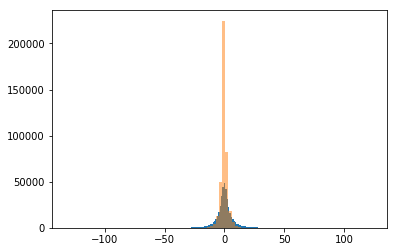

In [11]:
plt.hist(Forces['DFTB'] - Forces['DFT'],bins=100)
plt.hist(Forces['ANI'] - Forces['DFT'],bins=100, alpha=0.5)

plt.show()

In [12]:
from anitraintools import plot_corr_dist_ax

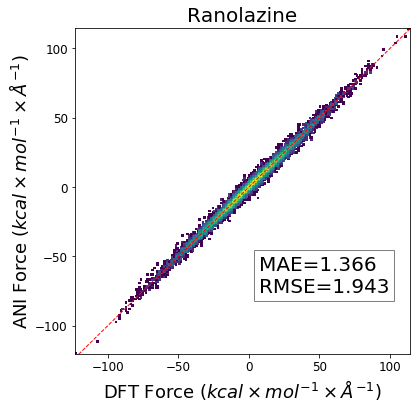

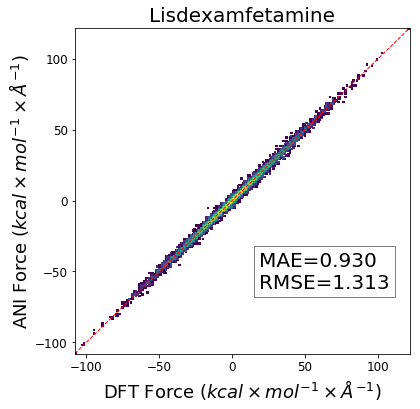

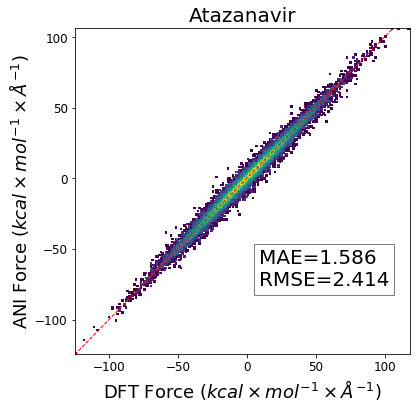

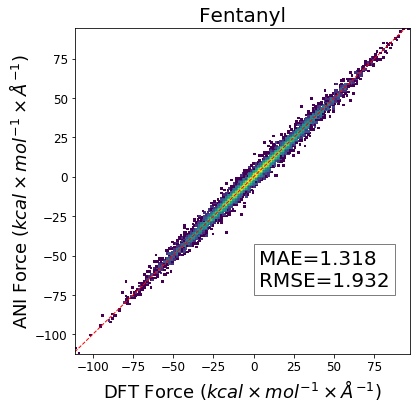

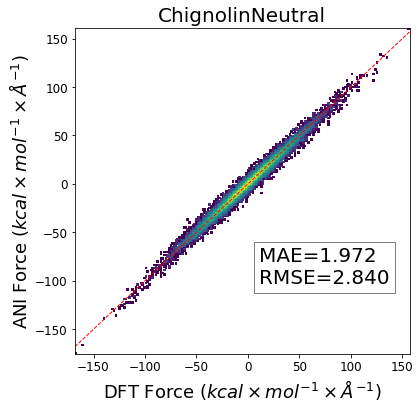

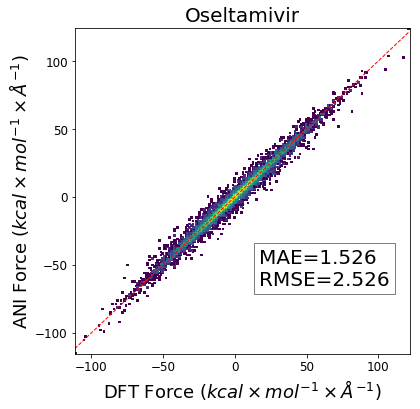

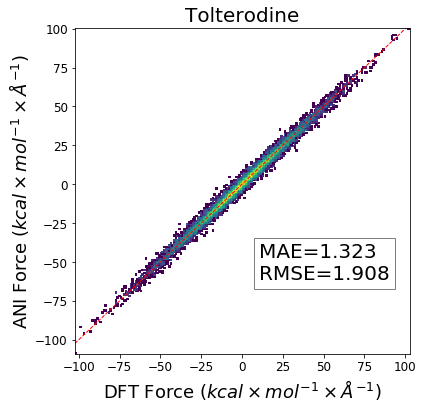

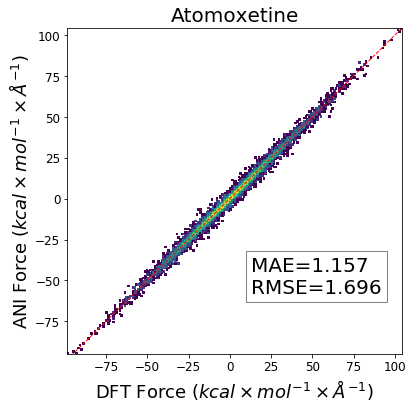

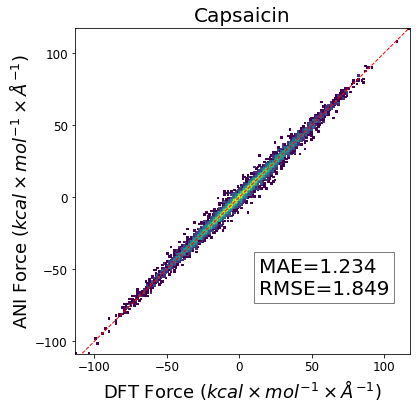

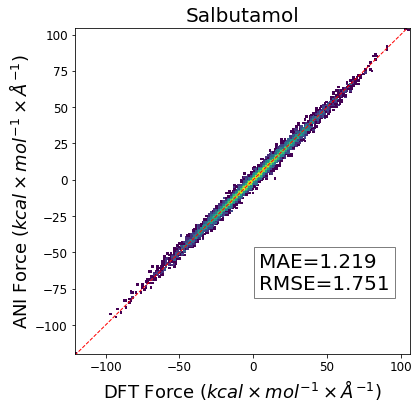

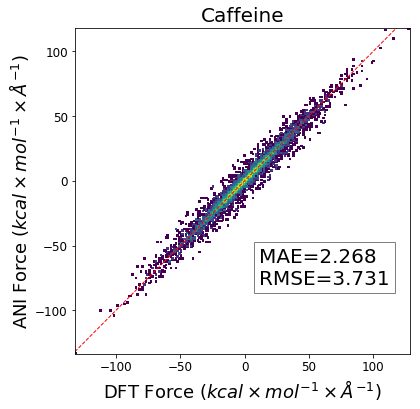

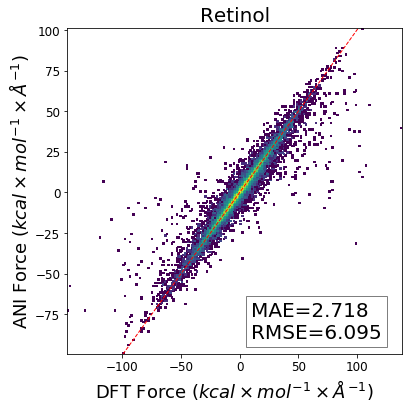

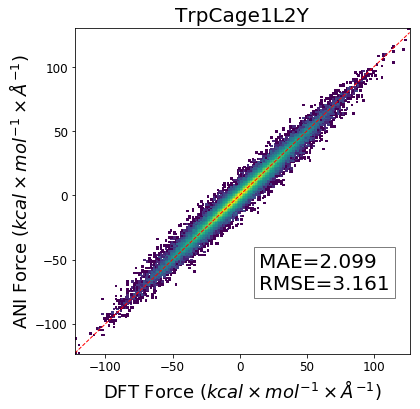

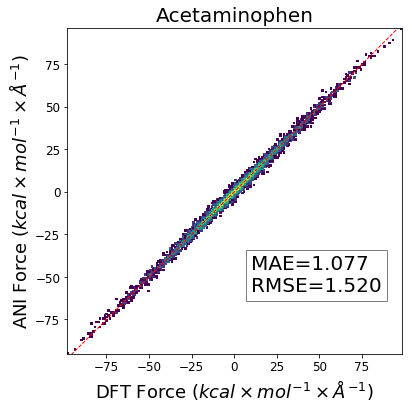

In [13]:
for key in forces['DFT'].keys():
    Ed = forces['DFT'][key]
    Ea = forces['ANI'][key]

    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(key,fontsize=20)
    plot_corr_dist_ax(ax,Ed,Ea,errors=True)
    ax.set_xlabel(r"DFT Force $(kcal\times mol^{-1} \times \AA^{-1})$",fontsize=18)
    ax.set_ylabel(r"ANI Force $(kcal\times mol^{-1} \times \AA^{-1})$",fontsize=18)
    
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.show()

#pp = PdfPages("/home/jujuman/Dropbox/ANAKIN-ME-RESEARCH/Figures/NEW-11-30-17/fent_ecorr_plot.pdf")
#pp.savefig(fig)
#pp.close()